In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from time import time
from PINN.European import EuropeanPINN
from PINN.utilities import V_BS, V_BS_CN

BS PDE
$$
\frac{\partial V}{\partial \tau}-\frac{\sigma^2 S^2}{2} \frac{\partial^2 V}{\partial S^2}-r S \frac{\partial V}{\partial S}+r V=0.
$$

For European put option, we have initial and boundary conditions
$$
V(S, 0) = (K - S)^+, V(0, \tau) = Ke^{-r\tau}, V(\infty, \tau) = 0.
$$

For European options, we have analytic solutions
$$
V(S, \tau)=K e^{-r \tau}\left(1-N\left(d_2\right)\right)+\left(N\left(d_1\right)-1\right) S,
$$
where
$$
d_1=\frac{\log (S / K)+\left(r+0.5 \sigma^2\right) \tau}{\sigma \sqrt{\tau}}, d_2=\frac{\log (S / K)+\left(r-0.5 \sigma^2\right) \tau}{\sigma \sqrt{\tau}}.
$$



In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
# load data
ib = torch.load('data/european_put_ib.pt')
pde = torch.load('data/european_put_pde.pt')
S_ib, tau_ib, V_ib = ib['S'], ib['tau'], ib['V']
S_pde, tau_pde = pde['S'], pde['tau']

# parameters
K = 4
sigma = 0.3
r = 0.03
T = 1
S_inf = 3 * K

TRAIN = False

Device: cuda


Number of parameters: 501


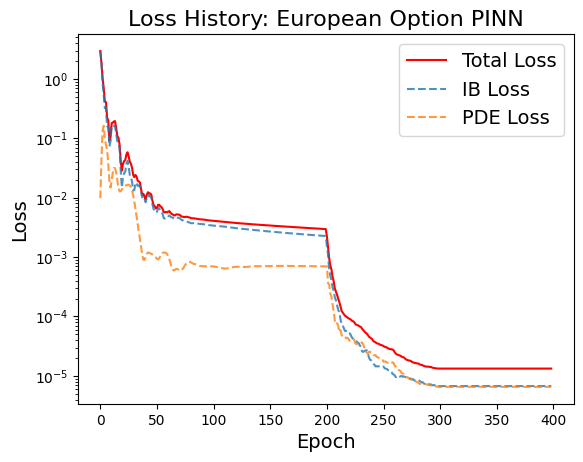

Final loss: 1.3270479485072428e-05


In [13]:
model_name = 'european_put_2mlp20'
if TRAIN:
    # nn = torch.nn.Sequential(
    #         torch.nn.Linear(2, 20),
    #         torch.nn.Tanh(),
    #         torch.nn.Linear(20, 20),
    #         torch.nn.Tanh(),
    #         torch.nn.Linear(20, 20),
    #         torch.nn.Tanh(),
    #         torch.nn.Linear(20, 1)
    # )  # adam(lr=0.1)200 + lbfgs200
    nn = torch.nn.Sequential(
            torch.nn.Linear(2, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 1)
    )  # adam(lr=0.05)200 + lbfgs200
    # nn = torch.nn.Sequential(
    #         torch.nn.Linear(2, 100),
    #         torch.nn.Tanh(),
    #         torch.nn.Linear(100, 1)
    # )  # adam(lr=0.5)200 + lbfgs200
    model = EuropeanPINN(nn, K, T, r, sigma, S_inf, device=device).to(device)

    training_time = time()
    # First train with Adam for 100 epochs
    model.train(S_ib, tau_ib, V_ib, S_pde, tau_pde, epochs=200, optimizer='adam', lr=0.05)
    # Then train with L-BFGS for 200 epochs
    model.train(S_ib, tau_ib, V_ib, S_pde, tau_pde, epochs=200, optimizer='lbfgs', line_search_fn='strong_wolfe')
    training_time = time() - training_time
    print('Training time:', training_time)
    # save model
    torch.save(model, f'models/{model_name}.pt')

model = torch.load(f'models/{model_name}.pt')
print('Number of parameters:', sum(p.numel() for p in model.parameters()))
model.plot_loss(data=False, save=True, title='Loss History: European Option PINN')
print('Final loss:', model.loss_history['total'][-1])

d:\APP_I\Python\Python311\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


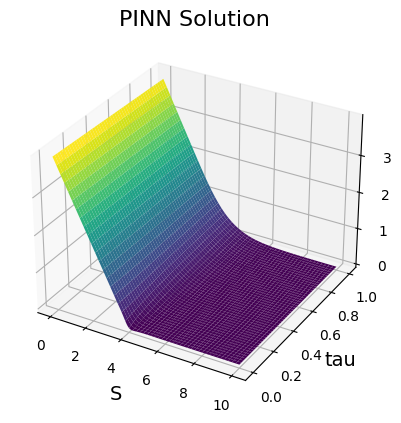

In [4]:
# load model
model = torch.load(f'models/{model_name}.pt').to('cpu')

S_plot = torch.linspace(0, 10, 1000)
tau_plot = torch.linspace(0, T, 1000)
S_plot, tau_plot = torch.meshgrid(S_plot, tau_plot)
V_plot = model(S_plot.reshape(-1, 1), tau_plot.reshape(-1, 1)).detach().reshape(1000, 1000)
# 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_plot.numpy(), tau_plot.numpy(), V_plot.numpy(), cmap='viridis')
ax.set_xlabel('S', fontsize=14)
ax.set_ylabel('tau', fontsize=14)
ax.set_zlabel('V', fontsize=14)
ax.set_title('PINN Solution', fontsize=16)
plt.savefig('./data/images/sol_european_3d.pdf')
plt.show()

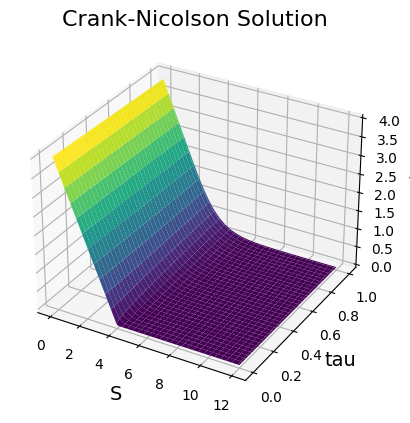

In [12]:
# Crank-Nicolson solution
V_CN, S_CN, t_CN = V_BS_CN(100, 100, T, K, sigma, r, S_inf)
V_CN_true = V_BS(S_CN, tau=T, K=K, r=r, sigma=sigma, type='put')

# Compute CN solution MSE
V_CN_true_full = np.zeros((t_CN.shape[0], S_CN.shape[0]))
for i in range(t_CN.shape[0]):
    V_CN_true_full[i] = V_BS(S_CN, tau=t_CN[i], K=K, r=r, sigma=sigma, type='put')
MSE_CN = np.mean((V_CN_true_full - V_CN)**2)

# 3d plot CN solution
S_plot, tau_plot = np.meshgrid(S_CN, t_CN)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_plot, tau_plot, V_CN, cmap='viridis')
ax.set_xlabel('S', fontsize=14)
ax.set_ylabel('tau', fontsize=14)
ax.set_zlabel('V', fontsize=14)
ax.set_title('Crank-Nicolson Solution', fontsize=16)
plt.show()

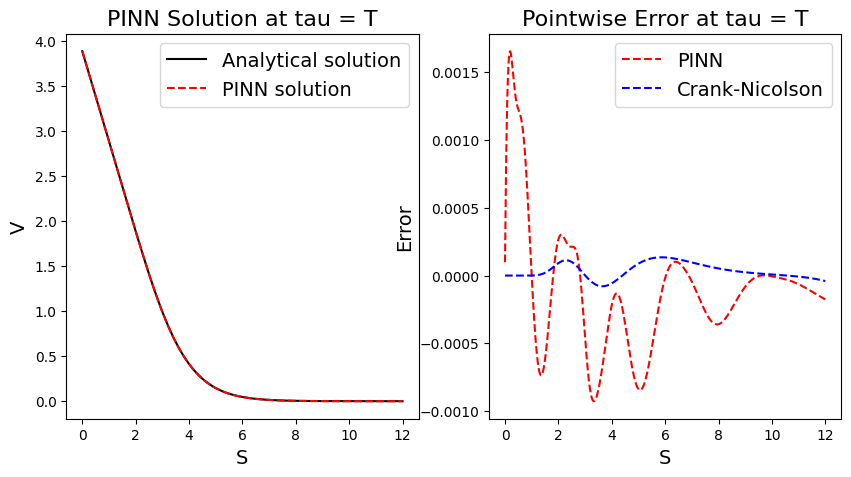

Crank-Nicolson MSE:  6.720318797744881e-09
PINN MSE:  1.3270479485072428e-05


In [10]:
# load model
model = torch.load(f'models/{model_name}.pt').to('cpu')

# plot tau = T
S_plot = torch.linspace(0, S_inf, 1000)
V_plot = model(S_plot.reshape(-1, 1), (torch.ones(1000, 1))*T).reshape(-1).detach()
V_true = V_BS(S_plot.detach().numpy(), tau=T, K=K, r=r, sigma=sigma, type='put')
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(S_plot, V_true, label='Analytical solution', c='k')
plt.plot(S_plot, V_plot, label='PINN solution', ls='--', c='r')
# plt.plot(S_CN, V_CN[-1, :], label='Crank-Nicolson solution')
plt.xlabel('S', fontsize=14)
plt.ylabel('V', fontsize=14)
plt.title('PINN Solution at tau = T', fontsize=16)
plt.legend(fontsize=14)

# plot pointwise error at tau = T
plt.subplot(122)
plt.plot(S_plot, V_plot - V_true, ls='--', c='r', label='PINN')
plt.plot(S_CN, V_CN[-1, :] - V_CN_true, ls='--', c='b', label='Crank-Nicolson')
plt.xlabel('S', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Pointwise Error at tau = T', fontsize=16)
plt.legend(fontsize=14)

plt.savefig('./data/images/sol_european.pdf')
plt.show()

print('Crank-Nicolson MSE: ', MSE_CN)
print('PINN MSE: ', model.loss_history['total'][-1])